In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import statsmodels.api as sm

movies_full = pd.read_csv('data/imdb1000_data.csv')

# Dataset Description: IMDb Top 1000 Movies

This dataset contains information about the top 1000 movies rated on IMDb. Below is a description of each column:

| Column | Description |
|--------|-------------|
| **Poster_Link** | URL to the movie poster image on IMDb |
| **Series_Title** | Title of the movie |
| **Released_Year** | Year in which the movie was released |
| **Certificate** | Rating certificate (e.g., A, U, UA) |
| **Runtime** | Total runtime of the movie in minutes |
| **Genre** | Categories/genres the movie belongs to |
| **IMDB_Rating** | Movie rating on IMDb (scale of 1-10) |
| **Overview** | Brief summary or plot description of the movie |
| **Meta_score** | Score earned on Metacritic (scale of 1-100) |
| **Director** | Name of the movie's director |
| **Star1** | Name of the lead actor/actress |
| **Star2** | Name of the second lead actor/actress |
| **Star3** | Name of the third lead actor/actress |
| **Star4** | Name of the fourth lead actor/actress |
| **No_of_Votes** | Total number of votes received on IMDb |
| **Gross** | Box office earnings of the movie in dollars |

The dataset contains 1000 entries with 16 columns. Some columns like Certificate (10.1% missing) and Meta_score (15.7% missing) contain null values.

In [69]:
movies = movies_full.drop(columns=['Poster_Link', 'Overview', 'Star3', 'Star4', 'No_of_Votes'])
movies = movies.set_index('Series_Title')
movies.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross
Series_Title,,,,,,,,,,
The Shawshank Redemption,1994,A,142 min,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,"28,341,469"
The Godfather,1972,A,175 min,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,"134,966,411"
The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,"534,858,444"
The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,"57,300,000"
12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,"4,360,000"


In [70]:
movies['Released_Year'] = pd.to_numeric(movies['Released_Year'], errors='coerce')
# movies['No_of_Votes'] = pd.to_numeric(movies['No_of_Votes'], errors='coerce')
movies['Released_Year'].dropna().unique()
movies['Runtime'] = movies['Runtime'].str.split(' ').str[0].astype(int)
movies['Gross'] = movies['Gross'].str.replace(',', '')
movies['Gross'] = pd.to_numeric(movies['Gross'], errors='coerce')
movies.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross
Series_Title,,,,,,,,,,
The Shawshank Redemption,1994.0,A,142,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,28341469.0
The Godfather,1972.0,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,134966411.0
The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,534858444.0
The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,57300000.0
12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,4360000.0


In [71]:
movies['Certificate'].unique()

array(['A', 'UA', 'U', 'PG-13', 'R', nan, 'PG', 'G', 'Passed', 'TV-14',
       '16', 'TV-MA', 'Unrated', 'GP', 'Approved', 'TV-PG', 'U/A'],
      dtype=object)

In [72]:
print('The number of missing values: ')
for item in movies.columns:
    print(f'{item} - {movies[item].isnull().sum()}')

The number of missing values: 
Released_Year - 1
Certificate - 101
Runtime - 0
Genre - 0
IMDB_Rating - 0
Meta_score - 157
Director - 0
Star1 - 0
Star2 - 0
Gross - 169


In [73]:
movies.sort_values(by='Released_Year', ascending=False).head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross
Series_Title,,,,,,,,,,
Druk,2020.0,NaN,117,"Comedy, Drama",7.8,81.0,Thomas Vinterberg,Mads Mikkelsen,Thomas Bo Larsen,NaN
Hamilton,2020.0,PG-13,160,"Biography, Drama, History",8.6,90.0,Thomas Kail,Lin-Manuel Miranda,Phillipa Soo,NaN
Dil Bechara,2020.0,UA,101,"Comedy, Drama, Romance",7.9,NaN,Mukesh Chhabra,Sushant Singh Rajput,Sanjana Sanghi,NaN
Soul,2020.0,U,100,"Animation, Adventure, Comedy",8.1,83.0,Pete Docter,Kemp Powers,Jamie Foxx,NaN
The Trial of the Chicago 7,2020.0,R,129,"Drama, History, Thriller",7.8,77.0,Aaron Sorkin,Eddie Redmayne,Alex Sharp,NaN


In [74]:
meta_score = movies['Meta_score']
imdb_score = movies['IMDB_Rating'] * 10
critics_score = pd.concat([meta_score, imdb_score], axis=1)
critics_score = critics_score.dropna()
critics_score.describe()

,Meta_score,IMDB_Rating
count,843.000000,843.000000
mean,77.971530,79.316726
std,12.376099,2.837322
min,28.000000,76.000000
25%,70.000000,77.000000
50%,79.000000,79.000000
75%,87.000000,81.000000
max,100.000000,93.000000


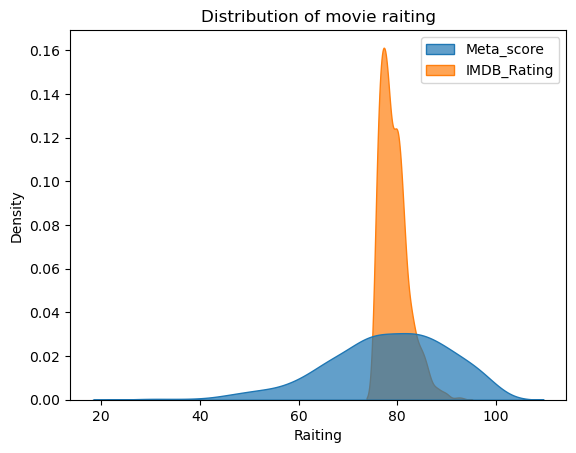

In [75]:
sns.kdeplot(data=critics_score, fill=True, alpha=0.7, common_norm=False)
plt.title('Distribution of movie raiting')
plt.ylabel('Density')
plt.xlabel('Raiting')
plt.show()

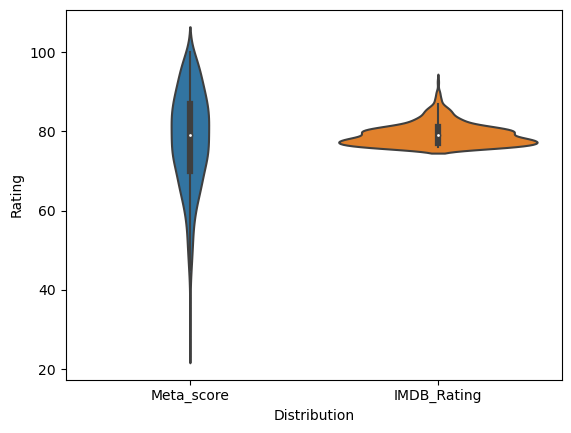

In [76]:
sns.violinplot(data=critics_score)
plt.ylabel('Rating')
plt.xlabel('Distribution')
plt.show()

# T-testing
There is a statistically significant difference between IMDb and Metacritic scores for the movies analyzed. The p-value (0.0021) is much smaller than the standard threshold of 0.05, meaning the difference is unlikely to be due to random chance.

In [77]:
t_test = sp.ttest_ind(critics_score["IMDB_Rating"], critics_score["Meta_score"], alternative = "two-sided")
t_test.pvalue

0.002131446476396098

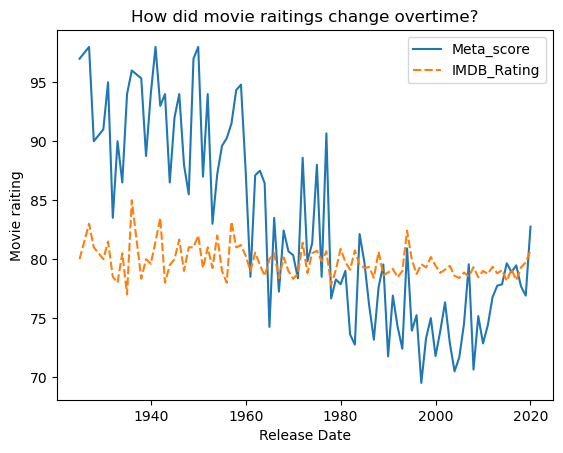

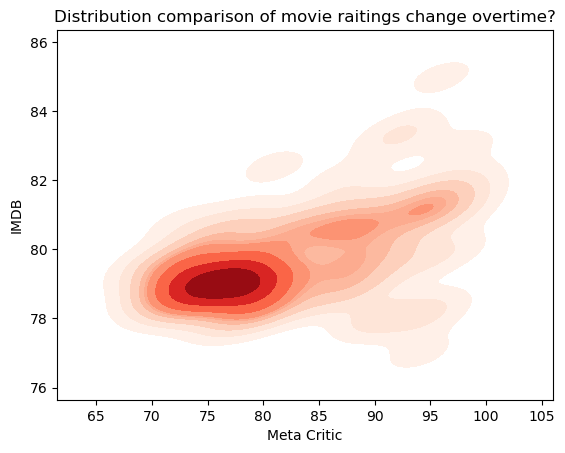

In [78]:
movies_time = pd.concat([meta_score, imdb_score, movies['Released_Year']], axis=1).dropna()

movies_by_year = movies_time.groupby('Released_Year').agg({
	'Meta_score': 'mean',
	'IMDB_Rating': 'mean'
}).reset_index()

movies_by_year = movies_by_year.set_index('Released_Year')
sns.lineplot(data=movies_by_year)
plt.title('How did movie raitings change overtime?')
plt.ylabel('Movie raiting')
plt.xlabel('Release Date')
plt.show()
sns.kdeplot(x=movies_by_year.Meta_score, y=movies_by_year.IMDB_Rating, cmap="Reds", fill=True, bw_adjust=0.7)
plt.title('Distribution comparison of movie raitings change overtime?')
plt.xlabel('Meta Critic')
plt.ylabel('IMDB')
plt.show()

Ttest here

In [79]:
t_test = sp.ttest_ind(movies_by_year["IMDB_Rating"], movies_by_year["Meta_score"], alternative = "two-sided")
t_test.pvalue

0.0007288994624564086

# Checking for linear reletionship for future multiple regression model

In [80]:
formula_string = "IMDB_Rating ~ Runtime"
model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()

model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     62.68
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           6.44e-15
Time:                        14:21:18   Log-Likelihood:                -98.782
No. Observations:                1000   AIC:                             201.6
Df Residuals:                     998   BIC:                             211.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6563      0.038    201.718      0.000       7.582       7.731
Runtime        0.0024      0.000      7.917      0.000       0.002       0.003
==============================================================================
Omnibus:                      128.871   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.884
Skew:                           0.911   Prob(JB):                     5.85e-42
Kurtosis:                       4.114   Cond. No.                         566.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Equation for regression model: <br>
IMDB_Rating = 7.57 + 0.0024 * Runtime <br>
The model returns an adj r-squared value of 0.067, meaning that this model explains 6.7% of the variability of IMDB rating. <br>
The coefficient for Runtime is 0.003 . This means that for an increase of 1 minute of runtime,  IMDB Rating increases by 0.003. The graph below demonstrates this.


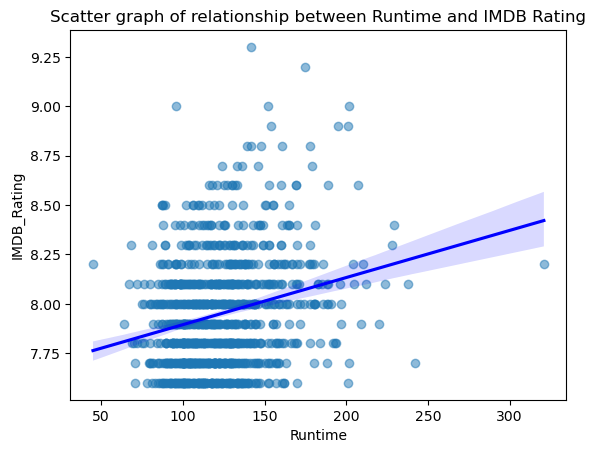

In [81]:
sns.regplot(x = movies['Runtime'] , y = movies['IMDB_Rating'] , scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'})
plt.title('Scatter graph of relationship between Runtime and IMDB Rating')
plt.show()

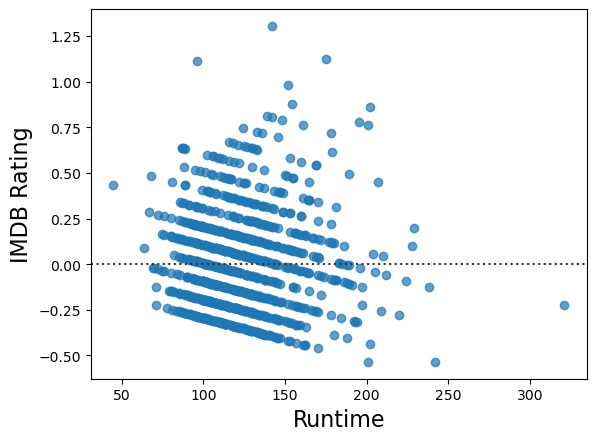

In [82]:
# model diagnostics, assessing the conditions for linear regression
sns.residplot(data = movies, x = 'Runtime' , y = 'IMDB_Rating', scatter_kws={'alpha': 0.7})
plt.xlabel('Runtime', fontsize = 16)
plt.ylabel('IMDB Rating', fontsize = 16)
plt.title('')
plt.show()

The pattern of residuals looks as though the distribution of residuals may be uneven, a histogram would make this more clear


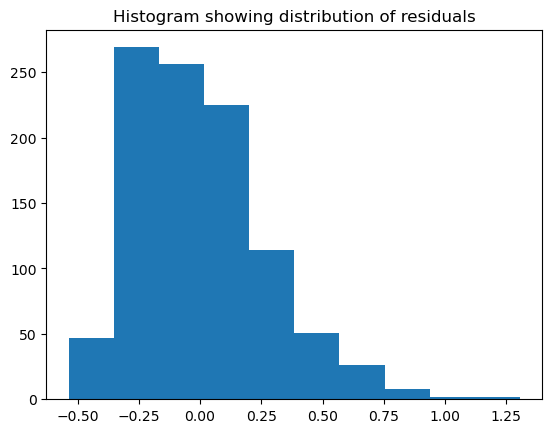

In [83]:
x = movies['Runtime']
y = movies['IMDB_Rating']
y_pred = model_fitted.predict(x)
residuals = y - y_pred
plt.hist(residuals, bins = 10)
plt.title('Histogram showing distribution of residuals')
plt.show();


## Interpretation of Histogram

The distribution of residuals appears skewed to the right rather than normally distributed. This non-normal distribution indicates that:

- The model may be less reliable at predicting IMDB Ratings for movies of certain runtimes
- There may be systematic errors in the predictions

## Creating a multiple regression model

Certificate

# Certificate Categorization for Model Analysis

To include 'certificate' in the model, we converted it to a categorical variable with only two options:

- **Kids (1)**: Includes ratings such as A, UA, U/A, U, PG-13, TV-14, PG, TV-PG, G, Passed, and Approved
- **Adult (0)**: Includes ratings such as R, 16, GP, TV-MA, and Unrated

This binary categorisation allows us to analyze whether age appropriateness of movies has an impact on their IMDB ratings in our regression model.

In [84]:
movies = movies.dropna()
movies = movies.copy()

kid_movies = ['A', 'UA', 'U/A' , 'U' , 'PG-13' , 'TV-14', 'PG' ,'TV-PG', 'G' ,'Passed', 'Approved']
adult_movies = ['R', '16', 'GP', 'TV-MA', 'Unrated']
def classify_cert(row):
    if row in kid_movies:
        return 1
    elif row in adult_movies:
        return 0
    else:
        print('There is a NaN value')
        return np.nan
    
movies['Certificate_category'] = movies['Certificate'].apply(classify_cert)
movies.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross,Certificate_category
Series_Title,,,,,,,,,,,
The Shawshank Redemption,1994.0,A,142,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,28341469.0,1
The Godfather,1972.0,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,134966411.0,1
The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,534858444.0,1
The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,57300000.0,1
12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,4360000.0,1


# Main actor, secondary actor

Actors can have a great impact on how good the movie is. That's why we created categorical label for them on how many times they appeared in the top1000 movies list. We will rate them from 1 to 3:

1. **Only 1 appearance** - Actors who appear just once in the dataset
2. **2-5 appearances** - Actors with moderate representation
3. **More than 5 appearances** - Prolific actors with significant presence

These categories will help us analyze whether actor experience and popularity correlate with movie ratings in our regression model.

In [85]:
n_as_star1 = movies['Star1'].value_counts()
n_as_star2 = movies['Star2'].value_counts()
rs_combined = n_as_star1.add(n_as_star2, fill_value=0)
categorised_stars = pd.cut(rs_combined, [0, 1, 5, 15], labels=[1, 2, 3])
# Here's a breakdown on these categories
categorised_stars.value_counts()

1    694
2    219
3     21
dtype: int64

In [86]:
# This will calculate the sum of their appearences as both star1 and star2
def categorise_stars(row):
    star1 = categorised_stars[row['Star1']]
    star2 = categorised_stars[row['Star2']]

    return star1 + star2

movies['Stars_Level'] = movies.apply(categorise_stars, axis=1)

# Director Impact Analysis

Directors are essential to a movie's success. We've created a categorical rating system based on how frequently directors appear in the top 1000 movies list:

1. **Only 1 appearance** - Directors with a single film in the dataset
2. **2-5 appearances** - Directors with moderate representation
3. **More than 5 appearances** - Prolific directors with significant presence

This categorization allows us to analyze whether director experience and prominence correlate with movie ratings in our regression model.

In [87]:
def categorise_director(row):
    categorised_director = pd.cut(movies['Director'].value_counts(), [0, 1, 5, 20], labels=[1, 2, 3])
    return categorised_director[row]

movies['Director_Level'] = movies['Director'].apply(categorise_director)

# Multiple regression model

In [88]:
formula_string = "IMDB_Rating ~ Runtime + Certificate_category + Gross + Released_Year + Director_Level + Stars_Level"

model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()


model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     19.61
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           3.14e-21
Time:                        14:21:19   Log-Likelihood:                -81.510
No. Observations:                 713   AIC:                             177.0
Df Residuals:                     706   BIC:                             209.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.9804      1.170     11.098      0.000      10.684      15.277
Runtime                  0.0025      0.000      6.037      0.000       0.002       0.003
Certificate_category     0.0360      0.028      1.307      0.192      -0.018       0.090
Gross                 2.913e-10   9.85e-11      2.956      0.003    9.78e-11    4.85e-10
Released_Year           -0.0028      0.001     -4.742      0.000      -0.004      -0.002
Director_Level           0.0706      0.015      4.616      0.000       0.041       0.101
Stars_Level             -0.0063      0.010     -0.619      0.536      -0.026       0.014
==============================================================================
Omnibus:                       95.763   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.534
Skew:                           0.924   Prob(JB):                     1.85e-31
Kurtosis:                       4.161   Cond. No.                     1.59e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Regression Model Analysis

Using p-value as a selection criterion (variables must have p<.05 to be included), we performed backward selection:

1. Removed 'Stars_level' (p = .53)
2. Removed 'Certificate_category' (p = .19)

All remaining variables return statistically significant p-values, resulting in 4 predictors in the final model.

Among these 4 predictors, there doesn't appear to be any obvious collinearity, meaning this model should avoid complications from multicollinearity.

Note on variable selection: 
- Using 'n_of_votes' would increase the r-squared value significantly, however we cannot justify using it as a predictor
- It doesn't align with our research objectives since including it would suggest that voting on a movie makes it better (implausible causation)
- The dataset is also unclear whether 'n_of_votes' applies to just Metacritic, or both IMDB and Metacritic


In [89]:
formula_string = "IMDB_Rating ~ Runtime + Gross + Released_Year + Director_Level"

model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()


model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     28.89
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           2.89e-22
Time:                        14:21:19   Log-Likelihood:                -82.550
No. Observations:                 713   AIC:                             175.1
Df Residuals:                     708   BIC:                             197.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.3257      1.142     11.668      0.000      11.084      15.568
Runtime            0.0024      0.000      6.017      0.000       0.002       0.003
Gross           3.099e-10   9.32e-11      3.324      0.001    1.27e-10    4.93e-10
Released_Year     -0.0029      0.001     -5.133      0.000      -0.004      -0.002
Director_Level     0.0693      0.015      4.655      0.000       0.040       0.099
==============================================================================
Omnibus:                       96.901   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.775
Skew:                           0.932   Prob(JB):                     6.02e-32
Kurtosis:                       4.170   Cond. No.                     1.56e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# T values

In [90]:
np.abs(model_fitted.tvalues)

Intercept         11.668356
Runtime            6.016673
Gross              3.323827
Released_Year      5.132638
Director_Level     4.655255
dtype: float64

# Equation for multiple regression model: 

IMDB_Rating = 13.33 + 0.0024 * Runtime - 0.0029 * Released_Year + 0.0693 * Director_Level + 3.099e-10 * Gross

The model returned a higher adj R-squared value (0.135). This means that the model explains 13.5% of the variability of the outcome IMDB Rating, and predicts the outcome IMDB Rating more accurately.

If we look at T values for our model, Runtime is the biggest. That's why we **accept** our hypothesis on runtime being the best predictor of movie rating.

However, the low (0.135) adj. R-squared value of our model shows that it doesn't account for all possible values. There is a significant chance that there are better predictors not accounted for in our data/analysis.

Further analysis needs to be conducted.